In [1]:
import pandas as pd
from glob import glob
import os
from shutil import copyfile
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from numpy.random import permutation
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models.inception import inception_v3
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import os
from shutil import copyfile

%matplotlib inline

In [2]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [3]:
is_cuda = torch.cuda.is_available()
is_cuda

True

## Utility functions

In [4]:
def imshow(inp,cmap=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp,cmap)
    
class LayerActivations():
    features=[]
    
    def __init__(self,model):
        self.features = []
        self.hook = model.register_forward_hook(self.hook_fn)
    
    def hook_fn(self,module,input,output):
        
        self.features.extend(output.view(output.size(0),-1).cpu().data)

    
    def remove(self):
        
        self.hook.remove()
    
class FeaturesDataset(Dataset):
    
    def __init__(self,featlst,labellst):
        self.featlst = featlst
        self.labellst = labellst
        
    def __getitem__(self,index):
        return (self.featlst[index],self.labellst[index])
    
    def __len__(self):
        return len(self.labellst)
    
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target)
        
        running_loss += F.cross_entropy(output,target,size_average=False).data
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct.item()/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

## Creating PyTorch datasets

In [5]:
data_transform = transforms.Compose([
        transforms.Resize((299,299)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [6]:
# For Dogs & Cats dataset
train_dset = ImageFolder('../Chapter03/dogsandcats/train/',transform=data_transform)
val_dset = ImageFolder('../Chapter03/dogsandcats/valid/',transform=data_transform)
classes=2

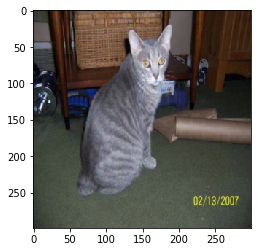

In [7]:
imshow(train_dset[150][0])

In [8]:
len(train_dset)

23000

## Creating data loader for training and validation datasets

In [9]:
train_loader = DataLoader(train_dset,batch_size=32,shuffle=False,num_workers=3)
val_loader = DataLoader(val_dset,batch_size=32,shuffle=False,num_workers=3)

## Creating Inception V3 model

In [10]:
my_inception = inception_v3(pretrained=True)
my_inception.aux_logits = False
for p in my_inception.parameters():
    p.requires_grad = False
if is_cuda:
    my_inception = my_inception.cuda()

## Extracting Convolutional features

In [11]:
# Create LayerActivations object to store the output of inception model at a particular layer.
trn_features = LayerActivations(my_inception.Mixed_7c)




In [12]:
# Passing all the data through the model , as a side effect the outputs will get stored 
# in the features list of the LayerActivations object. 
trn_labels = []
for da,la in train_loader:
    _ = my_inception(da.cuda())
    trn_labels.extend(la)
trn_features.remove()

In [13]:
# Repeat the same process for validation dataset .

val_features = LayerActivations(my_inception.Mixed_7c)
val_labels = []
for da,la in val_loader:
    _ = my_inception(Variable(da.cuda()))
    val_labels.extend(la)
val_features.remove()

In [14]:
len(val_labels)

2000

In [15]:
trn_features.features[0].size()

torch.Size([131072])

In [16]:
len(trn_features.features)

23000

## Creating train and validation feature dataset

In [17]:
#Dataset for pre computed features for train and validation data sets

trn_feat_dset = FeaturesDataset(trn_features.features,trn_labels)
val_feat_dset = FeaturesDataset(val_features.features,val_labels)

#Data loaders for pre computed features for train and validation data sets

trn_feat_loader = DataLoader(trn_feat_dset,batch_size=64,shuffle=True)
val_feat_loader = DataLoader(val_feat_dset,batch_size=64)

## A Fully connected network

In [18]:
class FullyConnectedModel(nn.Module):
    
    def __init__(self,in_size,out_size,training=True):
        super().__init__()
        self.fc = nn.Linear(in_size,out_size)

    def forward(self,inp):
        out = F.dropout(inp, training=self.training)
        out = self.fc(out)
        return out

# The size of the output from the selected convolution feature 
fc_in_size = 131072

fc = FullyConnectedModel(fc_in_size,classes)
if is_cuda:
    fc = fc.cuda()

In [19]:
optimizer = optim.Adam(fc.parameters(),lr=0.01)

## Train and validate the model

In [20]:

train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc.eval(),val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

/home/taewan/.local/lib/python3.7/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is   6.9 and training accuracy is 20512/23000     89.18
validation loss is   1.9 and validation accuracy is 1931/2000     96.55
training loss is   2.4 and training accuracy is 22113/23000     96.14
validation loss is   1.7 and validation accuracy is 1954/2000      97.7
training loss is   1.8 and training accuracy is 22384/23000     97.32
validation loss is   2.4 and validation accuracy is 1940/2000      97.0
training loss is   2.0 and training accuracy is 22415/23000     97.46
validation loss is   2.6 and validation accuracy is 1949/2000     97.45
training loss is   2.0 and training accuracy is 22479/23000     97.73
validation loss is   3.1 and validation accuracy is 1948/2000      97.4
training loss is   2.1 and training accuracy is 22515/23000     97.89
validation loss is   3.4 and validation accuracy is 1955/2000     97.75
training loss is   2.1 and training accuracy is 22567/23000     98.12
validation loss is   3.2 and validation accuracy is 1962/2000      98.1
traini

In [21]:
optimizer.param_groups[0]['lr']= 0.0001

In [22]:
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is  0.71 and training accuracy is 22825/23000     99.24
validation loss is   3.1 and validation accuracy is 1970/2000      98.5
training loss is  0.66 and training accuracy is 22845/23000     99.33
validation loss is   3.1 and validation accuracy is 1968/2000      98.4
training loss is  0.61 and training accuracy is 22861/23000      99.4
validation loss is   3.0 and validation accuracy is 1970/2000      98.5
training loss is  0.56 and training accuracy is 22869/23000     99.43
validation loss is   3.0 and validation accuracy is 1974/2000      98.7
training loss is  0.49 and training accuracy is 22855/23000     99.37
validation loss is   3.0 and validation accuracy is 1973/2000     98.65
training loss is   0.5 and training accuracy is 22871/23000     99.44
validation loss is   2.9 and validation accuracy is 1972/2000      98.6
training loss is  0.47 and training accuracy is 22865/23000     99.41
validation loss is   2.9 and validation accuracy is 1974/2000      98.7
traini

In [23]:
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is  0.46 and training accuracy is 22881/23000     99.48
validation loss is   2.9 and validation accuracy is 1972/2000      98.6
training loss is  0.37 and training accuracy is 22898/23000     99.56
validation loss is   2.8 and validation accuracy is 1973/2000     98.65
training loss is  0.39 and training accuracy is 22890/23000     99.52
validation loss is   2.8 and validation accuracy is 1972/2000      98.6
training loss is  0.35 and training accuracy is 22895/23000     99.54
validation loss is   2.9 and validation accuracy is 1973/2000     98.65
training loss is  0.43 and training accuracy is 22887/23000     99.51
validation loss is   2.8 and validation accuracy is 1975/2000     98.75
training loss is   0.3 and training accuracy is 22910/23000     99.61
validation loss is   2.7 and validation accuracy is 1976/2000      98.8
training loss is  0.35 and training accuracy is 22901/23000     99.57
validation loss is   2.7 and validation accuracy is 1976/2000      98.8
traini